# St Ebbes reference data work flow to support aggregations by COVID restriction data

## Imports

In [1]:
# Imports
#---------
import pandas as pd
import os
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter
import matplotlib as mpl
import statsmodels.api as sm

aurn_home = '/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/aurn/aurn_2016_2021/'
stats_home = '/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/gap_filling/536_method/lockdown_stats/'


## Load reference data
1-hour reference data for Oxford AURN & AQE stations obtained from Ricardo R data store. See also;

`/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/aurn/data_for_ajit/get_1hour_ox_auto_data.ipynb`

Using 6-years data 2016 to 2021 to estimate average conditions over this period. Reasoning for 6 years being, 2016 had low data capture & 2021 forms part of the study year.

Index(['OX', 'OX8', 'OX3', 'OX6'], dtype='object', name='code')

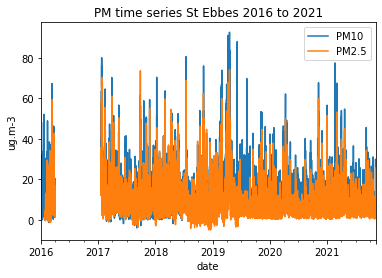

In [2]:
# Load 1-hour data 2016 to 2021
#-------------------------------

oxford_auto_20162021_1hr = pd.read_csv(aurn_home+'oxford_auto_20162021_1hr.csv.gz')#, index_col='date')
oxford_auto_20162021_1hr['date'] = pd.to_datetime(oxford_auto_20162021_1hr['date'], utc=True)
oxford_auto_20162021_1hr.set_index(['date','code','site'], inplace=True)
display(oxford_auto_20162021_1hr.index.get_level_values(1).unique())

oxford_auto_20162021_1hr.query('code == "OX8"').sort_index().reset_index().plot(x='date', 
                                                                                y=['PM10','PM2.5'], 
                                                                                title='PM time series St Ebbes 2016 to 2021',
                                                                                ylabel='ug.m-3')
plt.show()

Index(['OX', 'OX8', 'OX3', 'OX6'], dtype='object', name='code')

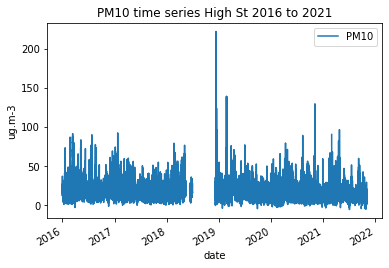

In [3]:
# Load 1-hour data 2016 to 2021
#-------------------------------

oxford_auto_20162021_1hr = pd.read_csv(aurn_home+'oxford_auto_20162021_1hr.csv.gz')#, index_col='date')
oxford_auto_20162021_1hr['date'] = pd.to_datetime(oxford_auto_20162021_1hr['date'], utc=True)
oxford_auto_20162021_1hr.set_index(['date','code','site'], inplace=True)
display(oxford_auto_20162021_1hr.index.get_level_values(1).unique())

oxford_auto_20162021_1hr.query('code == "OX6"').sort_index().reset_index().plot(x='date', 
                                                                                y=['PM10'], 
                                                                                title='PM10 time series High St 2016 to 2021',
                                                                                ylabel='ug.m-3')
plt.show()

## Reorganising the dataframe & aggregating
1-hour data reduced to St Ebbes & O2, PM10 & PM2.5 only. Data then grouped by the day of year, binning all 1-hour data across 6 years togther by ordinal day, then calculating descriptive statistics on these binned data. Key descriptive stats being the mean (of 1-hour observations) each day (daily mean) & the 95th percentile of hourly means each day.

These stats provide an indicator of the variation in typical & extreme concentrations influenced local conditions each day throughout the pandemic. In a later step we group & aggregate these descriptive stats further by restriction event to show temporal variations that will be influenced by the event(s) & meterologocal conditions.

In [5]:
# Housekeeping & aggregation
#-----------------------------
start16 = pd.to_datetime('2016-01-01', utc=True)
end19 = pd.to_datetime('2020-01-01', utc=True)

# Constrained to highs only
highs1619 = oxford_auto_20162021_1hr.query('code == "OX6" and @start16 <= date < @end19')
# Constrain to no2, pm10
highs = highs1619[['NO2','PM10']].reset_index(['code','site']) #.resample('1D', closed = 'right').mean() 
# aggregate by ordinal day
highs_ordinal_daymean = highs.groupby(highs.index.dayofyear).describe(percentiles=[0.90, 0.95])

# Sort index
s1 = highs_ordinal_daymean.iloc[:,[0,1,2,3,4,5,6,7]].add_prefix('no2_').columns.droplevel()
s2 = highs_ordinal_daymean.iloc[:,[8,9,10,11,12,13,14,15]].add_prefix('pm10_').columns.droplevel()

new_cols = list(s1.append([s2]))
highs_ordinal_daymean.columns = new_cols

highs_ordinal_daymean

,no2_count,no2_mean,no2_std,no2_min,no2_50%,no2_90%,no2_95%,no2_max,pm10_count,pm10_mean,pm10_std,pm10_min,pm10_50%,pm10_90%,pm10_95%,pm10_max
date,,,,,,,,,,,,,,,,
1,96.0,26.480272,11.450231,5.36972,26.775000,40.474305,43.303207,63.11250,92.0,14.415217,6.852206,4.1,13.95,23.19,25.190,37.0
2,96.0,45.037862,25.515096,3.82500,43.980050,81.345110,88.300698,91.51210,93.0,19.062366,9.494528,6.5,16.60,33.80,38.080,43.4
3,96.0,42.746203,24.550919,1.83408,39.119040,77.341975,85.945143,96.77365,92.0,20.360870,9.251599,6.8,17.35,35.67,39.225,43.9
4,95.0,47.894159,23.715728,4.14246,49.725000,77.886218,83.587506,97.29605,89.0,22.043820,13.663754,4.5,19.90,43.98,46.900,54.9
5,95.0,59.398605,29.105395,5.96649,61.200000,101.138232,111.548474,117.41077,96.0,22.232292,13.052707,4.3,21.10,38.00,45.250,74.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,96.0,48.068153,20.232371,17.60415,49.386300,76.512975,85.584375,97.53750,96.0,19.730208,11.299829,3.7,16.75,30.10,44.825,63.2
363,96.0,44.650914,27.103370,11.43440,42.056265,89.635840,99.928125,107.10000,96.0,19.582292,9.344123,5.8,17.20,33.65,39.050,45.7
364,96.0,45.299160,27.071157,3.61225,41.670980,80.360335,92.756250,116.66250,96.0,22.872917,11.468524,7.6,20.55,41.25,45.100,52.4


## Choosing metrics to demonstrate change
The graphs below demonstrate the pros & cons of 3 methods / metrics that could be used to demonstrate deviation from typical levels already experienced 2016-2021. Using the standard daily mean is shown to be potentially problematic because of the variation in the statistic throughout the year. As alternative we present 2 different initialisations LOWESS regression smoothing method which applies Locally Weighted Scatterplot Smoothing to smooth the peak in the standard daily mean, plus a rolling 28-day mean.

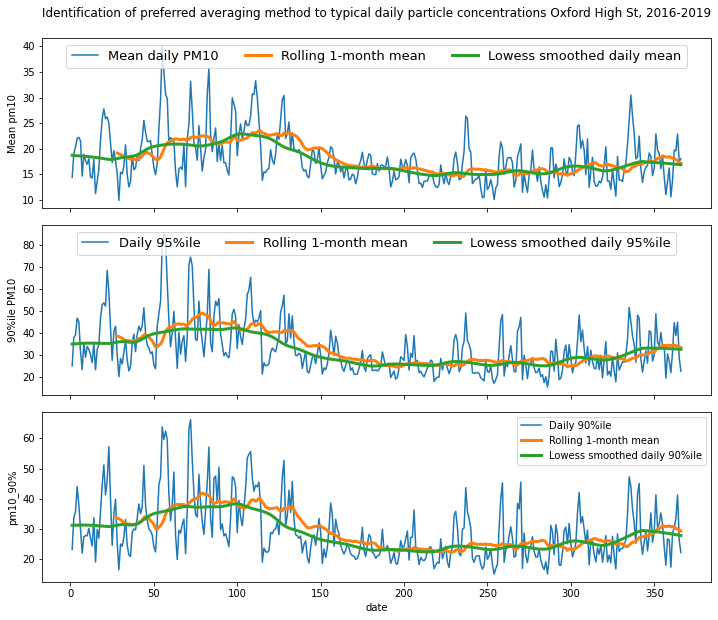

In [6]:
# Compare approaches to calculating mean dailt PM10 values by ordinal day
#-------------------------------------------------------------------------

# Doing PM10
#------------
figure, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12,10), sharex=True)

sns.lineplot(data=highs_ordinal_daymean, x=highs_ordinal_daymean.index, y='pm10_mean', ax=ax1, label='Mean daily PM10', lw=1.5)
sns.lineplot(data=highs_ordinal_daymean.rolling(28).mean(), 
             x=highs_ordinal_daymean.index, y='pm10_mean', ax=ax1, label='Rolling 1-month mean', lw=3)

smoothed_m2 = pd.DataFrame(sm.nonparametric.lowess
                           (exog=highs_ordinal_daymean.index, endog=highs_ordinal_daymean['pm10_mean'], frac=0.13, it=1),  columns=['x','y10'])

sns.lineplot(data=smoothed_m2, x='x', y='y10', ax=ax1, label='Lowess smoothed daily mean', lw=3)

highs_ordinal_daymean = highs_ordinal_daymean.reset_index().merge(smoothed_m2, left_on='date', right_on='x', how='left').drop('x',axis=1).set_index(['date'])

# Doing PM10, 95%ile
#--------------------
sns.lineplot(data=highs_ordinal_daymean, x=highs_ordinal_daymean.index, y='pm10_95%', ax=ax2, label='Daily 95%ile', lw=1.5)
sns.lineplot(data=highs_ordinal_daymean.rolling(28).mean(), x=highs_ordinal_daymean.index, y='pm10_95%', ax=ax2, label='Rolling 1-month mean', lw=3)

smoothed_m2 = pd.DataFrame(sm.nonparametric.lowess(exog=highs_ordinal_daymean.index, endog=highs_ordinal_daymean['pm10_95%'], frac=0.13, it=1),  columns=['x','ypm1095'])

sns.lineplot(data=smoothed_m2, x='x', y='ypm1095', ax=ax2, label='Lowess smoothed daily 95%ile', lw=3)

highs_ordinal_daymean = highs_ordinal_daymean.reset_index().merge(smoothed_m2, left_on='date', right_on='x', how='left').drop('x',axis=1).set_index(['date'])


ax1.set(xlabel='', ylabel = 'Mean pm10', title='Identification of preferred averaging method to typical daily particle concentrations Oxford High St, 2016-2019\n')
ax2.set(ylabel = '95%ile PM10')

ax1.legend(ncol=3, loc='upper center', fontsize=13)
ax2.legend(ncol=3, loc='upper center', fontsize=13)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# Doing PM10, 95%ile
#--------------------
sns.lineplot(data=highs_ordinal_daymean, x=highs_ordinal_daymean.index, y='pm10_90%', ax=ax3, label='Daily 90%ile', lw=1.5)
sns.lineplot(data=highs_ordinal_daymean.rolling(28).mean(), x=highs_ordinal_daymean.index, y='pm10_90%', ax=ax3, label='Rolling 1-month mean', lw=3)

smoothed_m2 = pd.DataFrame(sm.nonparametric.lowess(exog=highs_ordinal_daymean.index, endog=highs_ordinal_daymean['pm10_90%'], frac=0.13, it=1),  columns=['x','ypm1090'])

sns.lineplot(data=smoothed_m2, x='x', y='ypm1090', ax=ax3, label='Lowess smoothed daily 90%ile', lw=3)

highs_ordinal_daymean = highs_ordinal_daymean.reset_index().merge(smoothed_m2, left_on='date', right_on='x', how='left').drop('x',axis=1).set_index(['date'])


ax1.set(xlabel='', ylabel = 'Mean pm10', title='Identification of preferred averaging method to typical daily particle concentrations Oxford High St, 2016-2019\n')
ax2.set(ylabel = '90%ile PM10')

ax1.legend(ncol=3, loc='upper center', fontsize=13)
ax2.legend(ncol=3, loc='upper center', fontsize=13)
plt.subplots_adjust(wspace=0.1, hspace=0.1)


#plt.savefig(stats_home+'identifying_averging_methods_1619.png')

plt.show()


In [7]:
highs_ordinal_daymean.reset_index().to_feather(stats_home+'highs_ordinal_daymean_aggregates_2016_2019_9095.ftr') 
highs_ordinal_daymean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 1 to 366
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   no2_count   366 non-null    float64
 1   no2_mean    366 non-null    float64
 2   no2_std     366 non-null    float64
 3   no2_min     366 non-null    float64
 4   no2_50%     366 non-null    float64
 5   no2_90%     366 non-null    float64
 6   no2_95%     366 non-null    float64
 7   no2_max     366 non-null    float64
 8   pm10_count  366 non-null    float64
 9   pm10_mean   366 non-null    float64
 10  pm10_std    366 non-null    float64
 11  pm10_min    366 non-null    float64
 12  pm10_50%    366 non-null    float64
 13  pm10_90%    366 non-null    float64
 14  pm10_95%    366 non-null    float64
 15  pm10_max    366 non-null    float64
 16  y10         366 non-null    float64
 17  ypm1095     366 non-null    float64
 18  ypm1090     366 non-null    float64
dtypes: float64(19)
memory usage: 

In [8]:
highs_ordinal_daymean.head()

,no2_count,no2_mean,no2_std,no2_min,no2_50%,no2_90%,no2_95%,no2_max,pm10_count,pm10_mean,pm10_std,pm10_min,pm10_50%,pm10_90%,pm10_95%,pm10_max,y10,ypm1095,ypm1090
date,,,,,,,,,,,,,,,,,,,
1,96.0,26.480272,11.450231,5.36972,26.77500,40.474305,43.303207,63.11250,92.0,14.415217,6.852206,4.1,13.95,23.19,25.190,37.0,18.714141,35.115639,31.187848
2,96.0,45.037862,25.515096,3.82500,43.98005,81.345110,88.300698,91.51210,93.0,19.062366,9.494528,6.5,16.60,33.80,38.080,43.4,18.691451,35.170604,31.201833
3,96.0,42.746203,24.550919,1.83408,39.11904,77.341975,85.945143,96.77365,92.0,20.360870,9.251599,6.8,17.35,35.67,39.225,43.9,18.668626,35.223503,31.214800
4,95.0,47.894159,23.715728,4.14246,49.72500,77.886218,83.587506,97.29605,89.0,22.043820,13.663754,4.5,19.90,43.98,46.900,54.9,18.645727,35.274263,31.226698
5,95.0,59.398605,29.105395,5.96649,61.20000,101.138232,111.548474,117.41077,96.0,22.232292,13.052707,4.3,21.10,38.00,45.250,74.3,18.622737,35.322579,31.237233


## Define some functions to code up the ordinal days for by lockdown events
Have to do this in 2 hits because we have events that cover 2 years & data linked to ordinal / year agnostic days

In [9]:
def lockdown_codeup_ondate(df):
    df1 = df.reset_index().assign(ld_code=lambda x: x['rec'].apply(
        lambda y: 'a' if y < pd.to_datetime('2020-03-23', utc=True) else         # normal times
        ('b' if y < pd.to_datetime('2020-06-16', utc=True) else                   # lockdown 1
         ('c' if y < pd.to_datetime('2020-09-25', utc=True) else                   # easing 1-3 
          ('d' if y < pd.to_datetime('2020-11-05', utc=True) else                   # tier 1-2
           ('e' if y < pd.to_datetime('2020-12-02', utc=True) else                   # lockdown 2
            ('f' if y < pd.to_datetime('2021-01-05', utc=True) else                   # tier 4-2
             ('g' if y < pd.to_datetime('2021-03-08', utc=True) else                   # lockdown 3
              ('h' if y < pd.to_datetime('2021-04-12', utc=True) else                   # step 1
               ('i' if y < pd.to_datetime('2021-05-17', utc=True) else                   # step 2
                ('j' if y < pd.to_datetime('2021-06-21', utc=True) else 'k'               # step 3 else 17 # step 4
                )))))))))))
    return df1

def lockdown_codeup_onordinal_af(df):
    df1 = df.reset_index().assign(ld_code=lambda x: x['date'].apply(
        lambda y: 'a' if y < pd.to_datetime('2020-03-23', utc=True).dayofyear else         # normal times
        ('b' if y < pd.to_datetime('2020-06-16', utc=True).dayofyear else                    # lockdown 1
         ('c' if y < pd.to_datetime('2020-09-25', utc=True).dayofyear else                    # easing 1-3 
          ('d' if y < pd.to_datetime('2020-11-05', utc=True).dayofyear else                    # tier 1-2
           ('e' if y < pd.to_datetime('2020-12-02', utc=True).dayofyear else 'f'                # lockdown 2
             ))))))
    return df1                  
                  
def lockdown_codeup_onordinal_fk(df):
    df2 = df.reset_index().assign(ld_code=lambda x: x['date'].apply(
        lambda y: 'f' if y < pd.to_datetime('2021-01-05', utc=True).dayofyear else           # tier 4-2
        ('g' if y < pd.to_datetime('2021-03-08', utc=True).dayofyear else                    # lockdown 3
         ('h' if y < pd.to_datetime('2021-04-12', utc=True).dayofyear else                    # step1
          ('i' if y < pd.to_datetime('2021-05-17', utc=True).dayofyear else                    # step2
           ('j' if y < pd.to_datetime('2021-06-21', utc=True).dayofyear else  'k'               # step 3 else 17 # step 4
           ))))))
    return df2


In [10]:
# Code up the sensor data with lockdown codes by 'rec'
#------------------------------------------------------
highs_ordinal_daymean = pd.read_feather(stats_home+'highs_ordinal_daymean_aggregates_2016_2019_9095.ftr')
highs_ordinal_daymean_codeup_af = lockdown_codeup_onordinal_af(highs_ordinal_daymean)
highs_ordinal_daymean_codeup_af['ld_code'].unique()

array(['a', 'b', 'c', 'd', 'e', 'f'], dtype=object)

In [11]:
# Code up the sensor data with lockdown codes by 'rec'
#------------------------------------------------------
highs_ordinal_daymean = pd.read_feather(stats_home+'highs_ordinal_daymean_aggregates_2016_2019_9095.ftr')
highs_ordinal_daymean_codeup_fk = lockdown_codeup_onordinal_fk(highs_ordinal_daymean)
highs_ordinal_daymean_codeup_fk['ld_code'].unique()

array(['f', 'g', 'h', 'i', 'j', 'k'], dtype=object)

In [12]:
highs_ordinal_daymean_codeup_af.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       366 non-null    int64  
 1   date        366 non-null    int64  
 2   no2_count   366 non-null    float64
 3   no2_mean    366 non-null    float64
 4   no2_std     366 non-null    float64
 5   no2_min     366 non-null    float64
 6   no2_50%     366 non-null    float64
 7   no2_90%     366 non-null    float64
 8   no2_95%     366 non-null    float64
 9   no2_max     366 non-null    float64
 10  pm10_count  366 non-null    float64
 11  pm10_mean   366 non-null    float64
 12  pm10_std    366 non-null    float64
 13  pm10_min    366 non-null    float64
 14  pm10_50%    366 non-null    float64
 15  pm10_90%    366 non-null    float64
 16  pm10_95%    366 non-null    float64
 17  pm10_max    366 non-null    float64
 18  y10         366 non-null    float64
 19  ypm1095     366 non-null    f

In [13]:
highs_ordinal_daymean_codeup_fk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       366 non-null    int64  
 1   date        366 non-null    int64  
 2   no2_count   366 non-null    float64
 3   no2_mean    366 non-null    float64
 4   no2_std     366 non-null    float64
 5   no2_min     366 non-null    float64
 6   no2_50%     366 non-null    float64
 7   no2_90%     366 non-null    float64
 8   no2_95%     366 non-null    float64
 9   no2_max     366 non-null    float64
 10  pm10_count  366 non-null    float64
 11  pm10_mean   366 non-null    float64
 12  pm10_std    366 non-null    float64
 13  pm10_min    366 non-null    float64
 14  pm10_50%    366 non-null    float64
 15  pm10_90%    366 non-null    float64
 16  pm10_95%    366 non-null    float64
 17  pm10_max    366 non-null    float64
 18  y10         366 non-null    float64
 19  ypm1095     366 non-null    f

## Stats logic

### Arithmetic mean
For each lockdown event, calculate descriptive stats for that event based on the daily mean PM concentration. 

### LOWESS mean 
For each lockdown event, calculate descriptive stats for that event based on the daily mean PM concentration estimate based on preferred LOWESS bestfit line.

### 95th percentile
Two options;
1. For each lockdown event, calculate the 95%ile of daily 95%ile PM concentrations (calculated from 1-hour concentrations).
2. For each lockdown event, calculate the average daily 95%ile PM concentration for that event based on the daily 95%ile PM concentrations (calculated from 1-hour concentrations).
3. For each lockdown event, calculate the 95%ile of daily mean PM concentrations (calculated from 1-hour concentrations).

I think we want option (2) for percentiles.

In [14]:
highs_ordinal_daymean_codeup_ak = pd.concat([highs_ordinal_daymean_codeup_af, highs_ordinal_daymean_codeup_fk.query('date <= 292')]).reset_index(drop=True)

In [15]:
highs_ordinal_daymean_codeup_ak.to_feather(stats_home+'highs_ordinal_daymean_codeup_ak_1619_9095.ftr')
highs_ordinal_daymean_codeup_ak.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 658 entries, 0 to 657
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       658 non-null    int64  
 1   date        658 non-null    int64  
 2   no2_count   658 non-null    float64
 3   no2_mean    658 non-null    float64
 4   no2_std     658 non-null    float64
 5   no2_min     658 non-null    float64
 6   no2_50%     658 non-null    float64
 7   no2_90%     658 non-null    float64
 8   no2_95%     658 non-null    float64
 9   no2_max     658 non-null    float64
 10  pm10_count  658 non-null    float64
 11  pm10_mean   658 non-null    float64
 12  pm10_std    658 non-null    float64
 13  pm10_min    658 non-null    float64
 14  pm10_50%    658 non-null    float64
 15  pm10_90%    658 non-null    float64
 16  pm10_95%    658 non-null    float64
 17  pm10_max    658 non-null    float64
 18  y10         658 non-null    float64
 19  ypm1095     658 non-null    f

In [16]:
# pm10 arithemtic mean, events 'a' to 'k'
tmplist = []
for i, r in highs_ordinal_daymean_codeup_ak.groupby('ld_code'):
    tmp = r.groupby(['ld_code'])[['pm10_mean','pm10_50%','pm10_90%','pm10_95%','pm10_max']].mean()
    tmplist.append(tmp)
highs_ordinal_daymean_codeup_ak_mean_desc_pm10 = pd.concat(tmplist)
highs_ordinal_daymean_codeup_ak_mean_desc_pm10['poll'] = 'pm10'                     
highs_ordinal_daymean_codeup_ak_mean_desc_pm10.reset_index().to_feather(stats_home+'highs_ordinal_daymean_codeup_ak_mean_desc_pm10_1619_9095.ftr')

display(highs_ordinal_daymean_codeup_ak_mean_desc_pm10)

,pm10_mean,pm10_50%,pm10_90%,pm10_95%,pm10_max,poll
ld_code,,,,,,
a,20.078047,17.834756,35.389024,40.742439,52.934146,pm10
b,20.781314,19.137342,33.520886,37.346076,47.870886,pm10
c,15.655694,14.795794,23.782523,26.328271,37.128037,pm10
d,16.234175,15.401220,25.514146,27.808049,32.275610,pm10
e,16.129203,15.059259,25.154074,28.330185,34.100000,pm10
f,17.802929,16.054412,30.143824,34.115735,51.052941,pm10
g,19.766219,17.720161,34.205968,39.654597,52.158065,pm10
h,21.727538,19.201429,38.669143,43.835857,56.068571,pm10
i,22.708979,20.757143,36.356571,40.407857,51.102857,pm10


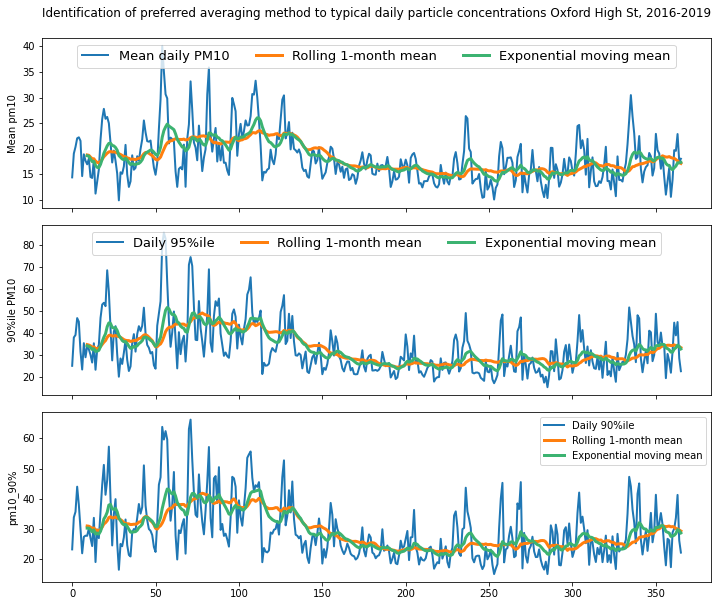

In [17]:
# Compare approaches to calculating mean dailt PM10 values by ordinal day
#-------------------------------------------------------------------------

highs_lowess_daymean = pd.DataFrame()

# Doing PM10
#------------
figure, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12,10), sharex=True)

sns.lineplot(data=highs_ordinal_daymean, x=highs_ordinal_daymean.index, y='pm10_mean', ax=ax1, label='Mean daily PM10', lw=2)
sns.lineplot(data=highs_ordinal_daymean.rolling(28, min_periods=10).mean(), x=highs_ordinal_daymean.index, y='pm10_mean', ax=ax1, label='Rolling 1-month mean', lw=3, color='tab:orange')
sns.lineplot(data=highs_ordinal_daymean.ewm(alpha=0.1, min_periods=10).mean(), x=highs_ordinal_daymean.index, y='pm10_mean', ax=ax1, label='Exponential moving mean', lw=3, color='mediumseagreen')

# Doing PM10, 95%ile
#--------------------
sns.lineplot(data=highs_ordinal_daymean, x=highs_ordinal_daymean.index, y='pm10_95%', ax=ax2, label='Daily 95%ile', lw=2)
sns.lineplot(data=highs_ordinal_daymean.rolling(28, min_periods=10).mean(), x=highs_ordinal_daymean.index, y='pm10_95%', ax=ax2, label='Rolling 1-month mean', lw=3, color='tab:orange')
sns.lineplot(data=highs_ordinal_daymean.ewm(alpha=0.1, min_periods=10).mean(), x=highs_ordinal_daymean.index, y='pm10_95%', ax=ax2, label='Exponential moving mean', lw=3, color='mediumseagreen')

# Doing PM10, 90%ile
#--------------------
sns.lineplot(data=highs_ordinal_daymean, x=highs_ordinal_daymean.index, y='pm10_90%', ax=ax3, label='Daily 90%ile', lw=2)
sns.lineplot(data=highs_ordinal_daymean.rolling(28, min_periods=10).mean(), x=highs_ordinal_daymean.index, y='pm10_90%', ax=ax3, label='Rolling 1-month mean', lw=3, color='tab:orange')
sns.lineplot(data=highs_ordinal_daymean.ewm(alpha=0.1, min_periods=10).mean(), x=highs_ordinal_daymean.index, y='pm10_90%', ax=ax3, label='Exponential moving mean', lw=3, color='mediumseagreen')

ax1.set(xlabel='', ylabel = 'Mean pm10', title='Identification of preferred averaging method to typical daily particle concentrations Oxford High St, 2016-2019\n')
ax2.set(ylabel = '90%ile PM10')

ax1.legend(ncol=3, loc='upper center', fontsize=13)
ax2.legend(ncol=3, loc='upper center', fontsize=13)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

#plt.savefig('identifying_averging_methods.png')

plt.show()

#highs_lowess_daymean.reset_index().to_feather(stats_home+'highs_lowess_daymean.ftr')


In [18]:
highs_ordinal_daymean

,date,no2_count,no2_mean,no2_std,no2_min,no2_50%,no2_90%,no2_95%,no2_max,pm10_count,pm10_mean,pm10_std,pm10_min,pm10_50%,pm10_90%,pm10_95%,pm10_max,y10,ypm1095,ypm1090
0,1,96.0,26.480272,11.450231,5.36972,26.775000,40.474305,43.303207,63.11250,92.0,14.415217,6.852206,4.1,13.95,23.19,25.190,37.0,18.714141,35.115639,31.187848
1,2,96.0,45.037862,25.515096,3.82500,43.980050,81.345110,88.300698,91.51210,93.0,19.062366,9.494528,6.5,16.60,33.80,38.080,43.4,18.691451,35.170604,31.201833
2,3,96.0,42.746203,24.550919,1.83408,39.119040,77.341975,85.945143,96.77365,92.0,20.360870,9.251599,6.8,17.35,35.67,39.225,43.9,18.668626,35.223503,31.214800
3,4,95.0,47.894159,23.715728,4.14246,49.725000,77.886218,83.587506,97.29605,89.0,22.043820,13.663754,4.5,19.90,43.98,46.900,54.9,18.645727,35.274263,31.226698
4,5,95.0,59.398605,29.105395,5.96649,61.200000,101.138232,111.548474,117.41077,96.0,22.232292,13.052707,4.3,21.10,38.00,45.250,74.3,18.622737,35.322579,31.237233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,362,96.0,48.068153,20.232371,17.60415,49.386300,76.512975,85.584375,97.53750,96.0,19.730208,11.299829,3.7,16.75,30.10,44.825,63.2,17.006454,32.891632,28.173541
362,363,96.0,44.650914,27.103370,11.43440,42.056265,89.635840,99.928125,107.10000,96.0,19.582292,9.344123,5.8,17.20,33.65,39.050,45.7,16.973841,32.840558,28.077101
363,364,96.0,45.299160,27.071157,3.61225,41.670980,80.360335,92.756250,116.66250,96.0,22.872917,11.468524,7.6,20.55,41.25,45.100,52.4,16.941959,32.788032,27.979620
364,365,96.0,41.451053,22.634996,1.36002,48.141790,69.641190,70.953907,80.32500,95.0,17.529474,7.444373,4.1,18.10,26.16,28.690,43.0,16.911104,32.734046,27.881270


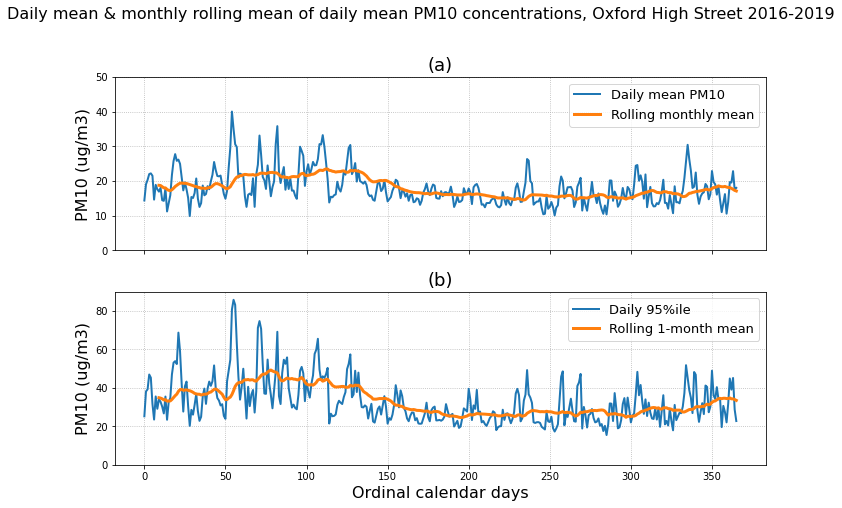

In [19]:
# Compare approaches to calculating mean dailt PM10 values by ordinal day
#-------------------------------------------------------------------------

#highs_lowess_daymean = pd.DataFrame()

# Doing PM10
#------------
figure, (ax1, ax2) = plt.subplots(2, figsize=(10,7), sharex=True)

sns.lineplot(data=highs_ordinal_daymean, x=highs_ordinal_daymean.index, y='pm10_mean', ax=ax1, label='Daily mean PM10', lw=2)
sns.lineplot(data=highs_ordinal_daymean.rolling(28, min_periods=10).mean(), x=highs_ordinal_daymean.index, y='pm10_mean', ax=ax1, label='Rolling monthly mean', lw=3, color='tab:orange')

# Doing PM10, 95%ile
#--------------------
sns.lineplot(data=highs_ordinal_daymean, x=highs_ordinal_daymean.index, y='pm10_95%', ax=ax2, label='Daily 95%ile', lw=2)
sns.lineplot(data=highs_ordinal_daymean.rolling(28, min_periods=10).mean(), x=highs_ordinal_daymean.index, y='pm10_95%', ax=ax2, label='Rolling 1-month mean', lw=3, color='tab:orange')
plt.rcParams.update({'font.size': 14})

ax1.set_title('(a)', fontsize=18)
ax2.set_title('(b)', fontsize=18)
ax1.set_ylabel('PM10 (ug/m3)', fontsize=16)
ax2.set_ylabel('PM10 (ug/m3)', fontsize=16)
ax2.set_xlabel('Ordinal calendar days', fontsize=16)
ax2.set_title('(b)', fontsize=18)

plt.suptitle('Daily mean & monthly rolling mean of daily mean PM10 concentrations, Oxford High Street 2016-2019', y=1.01, fontsize=16)
#plt.rcParams.update({'font.size': 14})
ax1.legend(ncol=1, loc='upper right',fontsize=13)
ax2.legend(ncol=1, loc='upper right', fontsize=13)
ax1.set_ylim(0,50)
ax2.set_ylim(0,90)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.tight_layout()
#plt.rcParams.update({'font.size': 17})
ax1.grid(True, ls=':')
ax2.grid(True, ls=':')

plt.savefig('pm10_pm25_24hr_1mrm_201619.png')

plt.show()

